/var/folders/gl/2q9xsmfd5ll6rjdlnqfslpqr0000gn/T/ipykernel_47164/2311183649.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(phi**2, x))


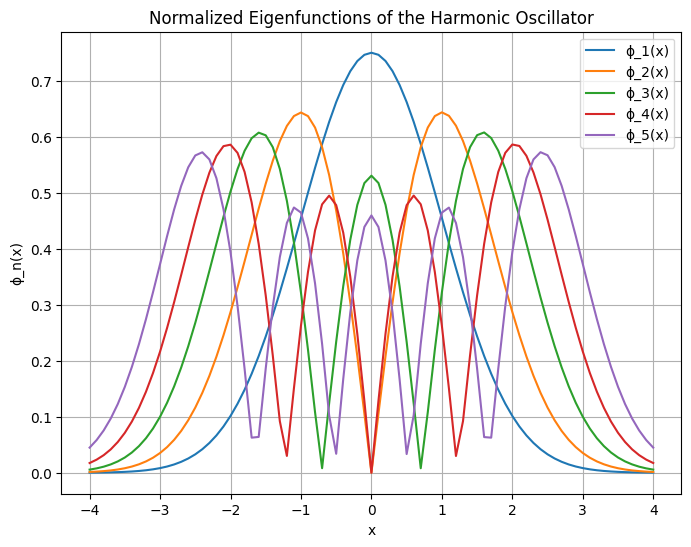

Eigenvalues (A2):
[0.99973579 2.9990026  4.99846306 6.99758103 8.99625435]


/var/folders/gl/2q9xsmfd5ll6rjdlnqfslpqr0000gn/T/ipykernel_47164/2311183649.py:137: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A3[:, i] /= np.sqrt(np.trapz(A3[:, i]**2, xspan))


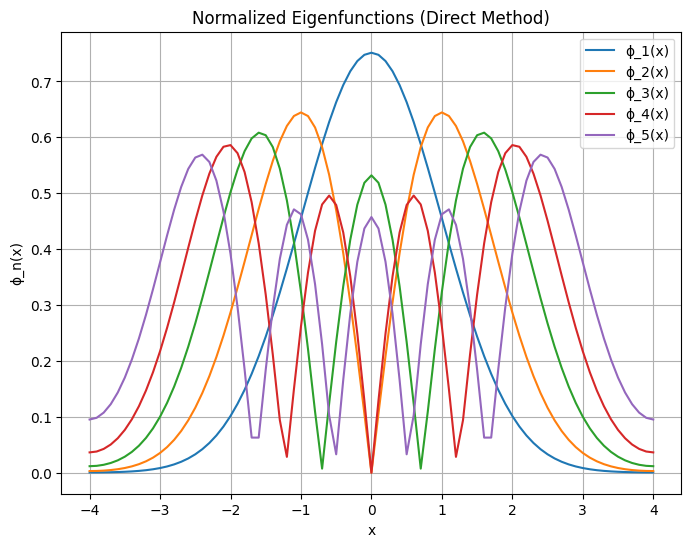

Eigenvalues (A4):
[0.99937352 2.996839   4.99140656 6.98038865 8.95060003]


In [130]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

# Parameters
L = 4       # Boundaries
K = 1       # Given K value
xspan = np.linspace(-L, L, 81, endpoint=True)
tol = 1e-4  # Tolerance for shooting

# Function to define the system of first-order ODEs
def harmonic_oscillator_ode(x, y, epsilon):
    """System of ODEs for the quantum harmonic oscillator."""
    return [y[1], (K * x**2 - epsilon) * y[0]]

# Function to perform the shooting method for a given eigenvalue guess
def shoot(epsilon_guess):
    """Solve the ODE for a given eigenvalue guess and return the solution at the boundary."""
    y0 = [1, np.sqrt(16 - epsilon_guess)]  # Initial conditions: ϕ(0) = 1, ϕ'(0) = 0
    
    # Use solve_ivp to solve the ODE
    sol = solve_ivp(harmonic_oscillator_ode, [xspan[0], xspan[-1]], y0, args=(epsilon_guess,), 
                    t_eval=xspan)
    return sol.y.T  # Return solution, transposed to match the original format

# Function to normalize the eigenfunction
def normalize(phi, x):
    """Normalize the eigenfunction using trapezoidal integration."""
    norm = np.sqrt(np.trapz(phi**2, x))
    return phi / norm

# Main function to compute eigenfunctions and eigenvalues
def compute_eigenfunctions_and_values(num_eigenvalues):
    eigenvalues = []
    eigenfunctions = []
    
    starting_guess = 0.1
    for i in range(1, 6):
        epsilon_guess = starting_guess
        dE = epsilon_guess / 100  # Step size for refining eigenvalue guess
        # Shooting method loop
        while True:
            # Solve ODE with current eigenvalue guess
            phi_L = shoot(epsilon_guess)  # Get value of ϕ(L) to check if it's close to 0
            # Check if we are close enough to the boundary condition ϕ(L) ≈ 0
            if np.abs((phi_L[-1, 1] + np.sqrt(16 - epsilon_guess) * phi_L[-1, 0])- 0) < tol:
                break
            if (-1) ** (i + 1) * (phi_L[-1, 1] + np.sqrt(16 - epsilon_guess) * phi_L[-1, 0]) > 0:
                epsilon_guess += dE
            else:
                epsilon_guess -= dE / 2  # If too low, increase epsilon
                dE /= 2  # Refine the step size
        # Store the found eigenvalue
        eigenvalues.append(epsilon_guess)
        starting_guess = epsilon_guess + 0.1
        # Solve again to get the eigenfunction with the found eigenvalue
        sol = shoot(epsilon_guess)
        phi = sol[:, 0]
        
        # Normalize the eigenfunction
        normalized_phi = normalize(phi, xspan)
        
        # Store the normalized eigenfunction
        eigenfunctions.append(normalized_phi)
    
    return np.array(eigenfunctions).T, np.array(eigenvalues)


# Compute the first 5 eigenfunctions and eigenvalues
A1, A2 = compute_eigenfunctions_and_values(5)

A1 = np.abs(A1)
# Plot the eigenfunctions
x_vals = np.linspace(-L, L, len(xspan))
plt.figure(figsize=(8, 6))
for i in range(A1.shape[1]):
    plt.plot(x_vals, A1[:, i], label=f'ϕ_{i+1}(x)')
plt.title('Normalized Eigenfunctions of the Harmonic Oscillator')
plt.xlabel('x')
plt.ylabel('ϕ_n(x)')
plt.legend()
plt.grid()
plt.show()


# Display the results
# print("Eigenfunctions (A1):")
# print(A1)
print("Eigenvalues (A2):")
print(A2)

N = len(xspan)  # Number of points
dx = 0.1       # Step size in x

# Initialize the matrix 
H = np.zeros((N - 2, N - 2))

# Fill the matrix with finite difference method
for i in range(0, N - 2):
    # Central difference for the interior points
    if i > 0:
        H[i, i - 1] = -1
    if i < N - 3:
        H[i, i + 1] = -1
    H[i, i] = 2 + (dx ** 2 * K * xspan[i + 1]**2)
    

# Boundary conditions using forward and backward differencing
# Forward difference for the first row
H[0, 0] = (2 + (dx ** 2 * K * xspan[1]**2)) - 4/3
H[0, 1] = -1 + 1/3
# H[0, 2] = 1 / (2 * dx**2)

# Backward difference for the last row
H[- 1, - 1] =  (2 + (dx ** 2 * K * xspan[N - 2]**2)) - 4/3
H[- 1, - 2] = -1 + 1/3 
# H[N - 1, N - 3] = 1 / (2 * dx**2)

# Compute eigenvalues and eigenfunctions
eigenvalues, eigenfunctions = eigs(H / dx ** 2, which="SM")

eigenfunctions = np.vstack(
                            (   
                                ((4/3) * eigenfunctions[0, :] - (1/3) * eigenfunctions[1, :]), 
                                eigenfunctions, 
                                ((4/3) * eigenfunctions[-1, :] - (1/3) * eigenfunctions[-2, :])
                            )
                          )
# Extract the first five eigenvalues and eigenfunctions
A4 = eigenvalues[0:5]  # The first 5 eigenvalues
A3 = eigenfunctions[:, 0:5]  # The first 5 eigenfunctions

A3 = np.abs(A3)
# Normalize the eigenfunctions
for i in range(5):
    A3[:, i] /= np.sqrt(np.trapz(A3[:, i]**2, xspan))

# Plot the eigenfunctions
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(xspan, A3[:, i], label=f'ϕ_{i+1}(x)')
plt.title('Normalized Eigenfunctions (Direct Method)')
plt.xlabel('x')
plt.ylabel('ϕ_n(x)')
plt.legend()
plt.grid()
plt.show()

# Display the results
# print("Eigenfunctions (A3):")
# print(A3)
print("Eigenvalues (A4):")
A3 = A3.real
A4 = A4.real
print(A4)



/var/folders/gl/2q9xsmfd5ll6rjdlnqfslpqr0000gn/T/ipykernel_47164/2837341812.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(sol.y[0,:]**2, sol.t)


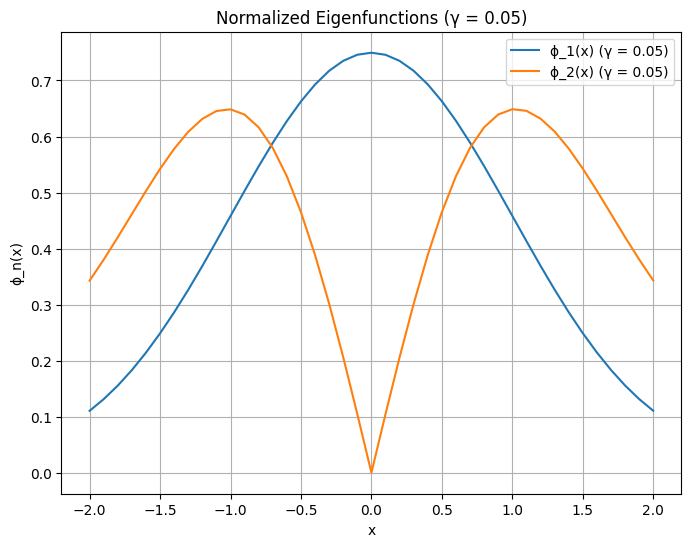

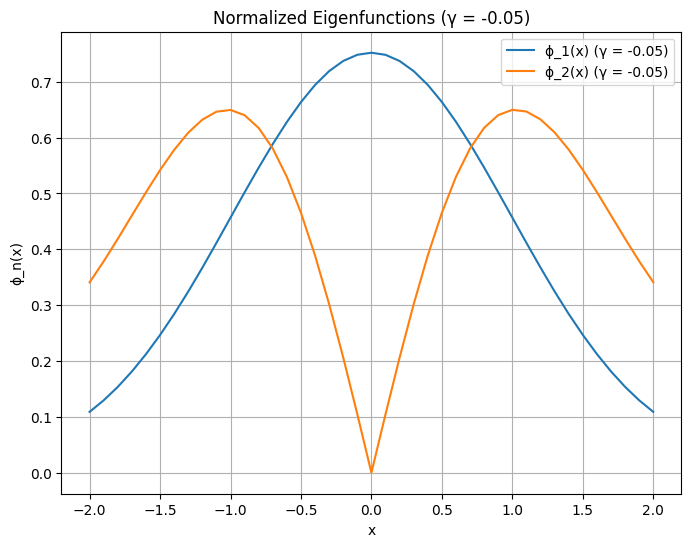

Eigenvalues (A6):
[1.01293945 2.92138672]
Eigenvalues (A8):
[0.97404785 2.89309082]


In [135]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
L = 2  # Boundaries
K = 1  # Given K value
xspan = np.linspace(-L, L, 41)  # xspan from -L to L with step size 0.1
tol = 1e-4  # Tolerance for shooting
gamma_values = [0.05, -0.05]  # gamma values for defocusing and focusing

# Function to define the system of first-order ODEs for nonlinear oscillator
def nonlinear_oscillator_ode(x, y, epsilon, gamma):
    """System of ODEs for the nonlinear harmonic oscillator."""
    return [y[1], (gamma * np.abs(y[0])**2 + K * x**2 - epsilon) * y[0]]

# Function to solve the ODE for a given eigenvalue guess using shooting
def shoot(epsilon_guess, gamma, A):
    """Solve the ODE for a given eigenvalue guess and return the solution at the boundary."""
    y0 = [A, A * np.sqrt(4 - epsilon_guess)]  # Initial conditions: ϕ(0) = 1, ϕ'(0) = 0
    sol = solve_ivp(nonlinear_oscillator_ode, [xspan[0], xspan[-1]], y0, args=(epsilon_guess, gamma), 
                    t_eval=xspan)
    return sol

# Function to normalize the eigenfunction
def normalize(phi, x):
    """Normalize the eigenfunction using trapezoidal integration."""
    norm = np.sqrt(np.trapz(phi**2, x))
    return phi / norm

# Function to compute eigenfunctions and eigenvalues using shooting method
def compute_nonlinear_modes(gamma, num_eigenvalues=2):
    A = 1e-6
    pEvals = []
    nEvals = []
    pEfunc = []
    nEfunc = []
    starting_guess = 0.1  # Initial guess for eigenvalue
    sol = None
    for i in range(1, 3):
        dA = 0.01
        while True:
            epsilon_guess = starting_guess
            dE = 0.2  # Step size for refining eigenvalue guess
            while True:
                sol = shoot(epsilon_guess, gamma, A)  # Solve ODE with current eigenvalue guess

                # Check if we are close enough to the boundary condition ϕ(L) ≈ 0
                # phi_L = sol.y[0, -1]  # Get the value of ϕ at x = L
                if np.abs((sol.y[1, -1] + np.sqrt(4 - epsilon_guess) * sol.y[0, -1])) < tol:
                    break
                if (-1) ** (i + 1) * (sol.y[1, -1] + np.sqrt(4 - epsilon_guess) * sol.y[0, -1]) > 0:
                    epsilon_guess += dE
                else:
                    epsilon_guess -= dE  # If too low, increase epsilon
                    dE /= 2  # Refine the step size
            area = np.trapz(sol.y[0,:]**2, sol.t)
            # print(area)
            if np.abs(area - 1) < tol:  # area update
                break
            if area < 1:
                A += dA
            else:
                A -= dA
                dA /= 2
        
        starting_guess = epsilon_guess + 0.2  # Update the guess for the next eigenvalue
        # Store the found eigenvalue
        if gamma > 0:
            pEvals.append(epsilon_guess)
            pEfunc.append(np.abs(sol.y[0]))
        else:
            nEvals.append(epsilon_guess)
            nEfunc.append(np.abs(sol.y[0]))
        # eigenvalues.append(epsilon_guess)
        
        
        # phi = sol.y[0]  # Extract the eigenfunction (first component)
        
        # Normalize the eigenfunction
        # normalized_phi = normalize(phi, xspan)
        
        # Store the normalized eigenfunction
        # eigenfunctions.append(normalized_phi)
    
        
    if gamma > 0:
        return np.array(pEfunc).T, np.array(pEvals)
    else:
        return np.array(nEfunc).T, np.array(nEvals)

# Compute the first 2 eigenfunctions and eigenvalues for γ = 0.05 and γ = -0.05
A5, A6 = compute_nonlinear_modes(gamma=0.05)
A7, A8 = compute_nonlinear_modes(gamma=-0.05)

# Plot the eigenfunctions for γ = 0.05
plt.figure(figsize=(8, 6))
for i in range(A5.shape[1]):
    plt.plot(xspan, np.abs(A5[:, i]), label=f'ϕ_{i+1}(x) (γ = 0.05)')
plt.title('Normalized Eigenfunctions (γ = 0.05)')
plt.xlabel('x')
plt.ylabel('ϕ_n(x)')
plt.legend()
plt.grid()
plt.show()

# Plot the eigenfunctions for γ = -0.05
plt.figure(figsize=(8, 6))
for i in range(A7.shape[1]):
    plt.plot(xspan, np.abs(A7[:, i]), label=f'ϕ_{i+1}(x) (γ = -0.05)')
plt.title('Normalized Eigenfunctions (γ = -0.05)')
plt.xlabel('x')
plt.ylabel('ϕ_n(x)')
plt.legend()
plt.grid()
plt.show()

# Display the results
# print("Eigenfunctions (A5):")
# print(A5)
print("Eigenvalues (A6):")
print(A6)

# print("Eigenfunctions (A7):")
# print(A7)
print("Eigenvalues (A8):")
print(A8)


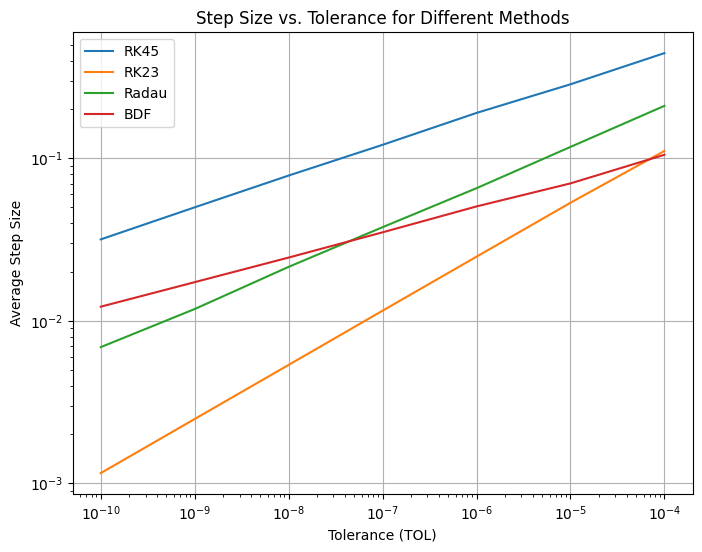

Slopes computed from polyfit: [5.24466756 3.01909953 4.03819927 6.45751261]


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
L = 2
K = 1  # Given K value
x_span = np.linspace(-L, L, 41)  # xspan from -L to L with 100 points
E = 1  # Energy
TOL = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]  # Different tolerance values

# Define the right-hand side of the equation (example)
def hw1_rhs_a(x, y, E):
    """Define the system of ODEs for the quantum harmonic oscillator."""
    return [y[1], (K * x**2 - 1) * y[0]]

# Initial conditions
phi_init = 1
phi_x_init = np.sqrt(3)
y0 = [phi_init, phi_x_init]

# Function to compute the solution with different methods and tolerances
def convergence_study():
    step_sizes = {'RK45': [], 'RK23': [], 'Radau': [], 'BDF': []}
    
    for tol in TOL:
        # Solve using RK45
        sol_rk45 = solve_ivp(hw1_rhs_a, [x_span[0], x_span[-1]], y0, method='RK45', args=(E,), rtol=tol, atol=tol)
        step_sizes['RK45'].append(np.mean(np.diff(sol_rk45.t)))
        
        # Solve using RK23
        sol_rk23 = solve_ivp(hw1_rhs_a, [x_span[0], x_span[-1]], y0, method='RK23', args=(E,), rtol=tol, atol=tol)
        step_sizes['RK23'].append(np.mean(np.diff(sol_rk23.t)))
        
        # Solve using Radau
        sol_radau = solve_ivp(hw1_rhs_a, [x_span[0], x_span[-1]], y0, method='Radau', args=(E,), rtol=tol, atol=tol)
        step_sizes['Radau'].append(np.mean(np.diff(sol_radau.t)))
        
        # Solve using BDF
        sol_bdf = solve_ivp(hw1_rhs_a, [x_span[0], x_span[-1]], y0, method='BDF', args=(E,), rtol=tol, atol=tol)
        step_sizes['BDF'].append(np.mean(np.diff(sol_bdf.t)))

    # Plot the log-log scale plot for each method
    plt.figure(figsize=(8, 6))
    for method, sizes in step_sizes.items():
        plt.loglog(TOL, sizes, label=f'{method}')
    
    plt.xlabel('Tolerance (TOL)')
    plt.ylabel('Average Step Size')
    plt.title('Step Size vs. Tolerance for Different Methods')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform polyfit to find slopes
    RK45 = np.polyfit(np.log(step_sizes['RK45']), np.log(TOL), 1)
    RK23 = np.polyfit(np.log(step_sizes['RK23']), np.log(TOL), 1)
    Radau = np.polyfit(np.log(step_sizes['Radau']), np.log(TOL), 1)
    BDF = np.polyfit(np.log(step_sizes['BDF']), np.log(TOL), 1)
    # slopes = {}
    # for method, sizes in step_sizes.items():
    #     slope, _ = np.polyfit(np.log(sizes), np.log(TOL), 1)
    #     slopes[method] = slope
    #     print(f'Slope for {method}: {slope}')
    
    # Return the slopes as a 4x1 vector
    return np.array([RK45[0], RK23[0], Radau[0], BDF[0]])
# Run the convergence study and plot
slopes = convergence_study()

# Save the slopes as A9
A9 = slopes
print("Slopes computed from polyfit:", A9)


/var/folders/gl/2q9xsmfd5ll6rjdlnqfslpqr0000gn/T/ipykernel_47164/3932012386.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz((np.abs(numerical) - np.abs(exact))**2, x)


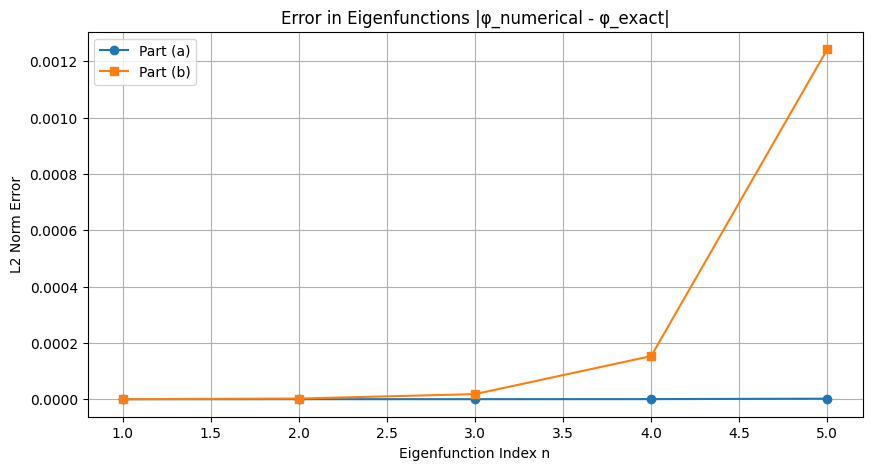

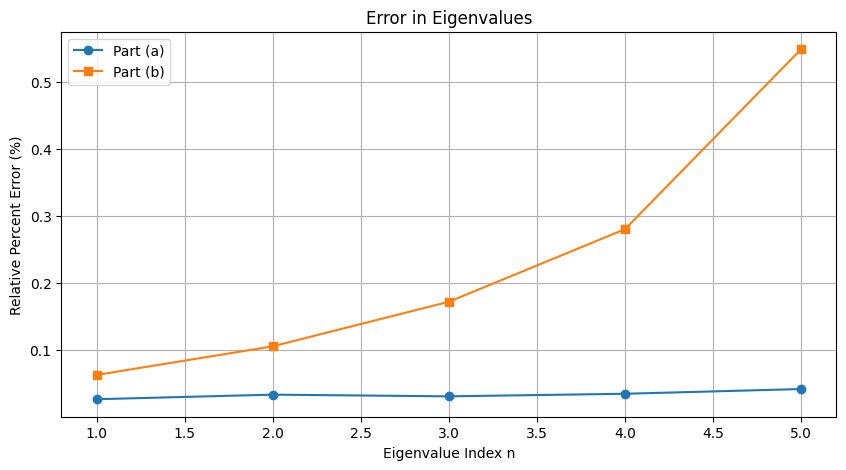

Eigenfunction Errors (Part a): [4.57692749e-08 1.72430898e-07 2.47858156e-07 4.35357225e-07
 1.96450610e-06]
Eigenvalue Errors (Part a): [0.02642089 0.0332466  0.03073885 0.03455668 0.04161829]
Eigenfunction Errors (Part b): [2.33908579e-07 2.39720320e-06 1.81275996e-05 1.53048072e-04
 1.24238600e-03]
Eigenvalue Errors (Part b): [0.0626477  0.10536673 0.1718688  0.28016214 0.54888859]


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

# Set parameters
L = 4
xspan = np.linspace(-L, L, 81)  # x values for calculating eigenfunctions
num_eigenvalues = 5  # Number of eigenfunctions/eigenvalues to compare



# Define the exact Gauss-Hermite eigenfunctions and eigenvalues
def exact_eigenfunction(n, x):
    """Compute exact nth eigenfunction using Hermite polynomials."""
    herm_array  = np.array([
        np.ones_like(x),                 # H_0(x)
        2 * x,                           # H_1(x)
        4 * x ** 2 - 2,                  # H_2(x)
        8 * x ** 3 - 12 * x,             # H_3(x)
        16 * x ** 4 - 48 * x ** 2 + 12,  # H_4(x)
    ])
    normalization_factor = np.sqrt(np.sqrt(np.pi) * 2 ** n * factorial(n))
    return ((herm_array[n, :] * np.exp(-x ** 2 / 2)) / normalization_factor).T

def exact_eigenvalue(n):
    """Return exact eigenvalue for nth state in a quantum harmonic oscillator."""
    return 2 * n + 1

# Define function to calculate L2 norm error
def l2_norm(numerical, exact, x):
    return np.trapz((np.abs(numerical) - np.abs(exact))**2, x)

# Calculate errors for eigenfunctions and eigenvalues
error_eigenfunctions_a = []
error_eigenvalues_a = []

for n in range(num_eigenvalues):
    exact_phi = exact_eigenfunction(n, xspan)
    numerical_phi = A1[:, n]
    error_phi = l2_norm(numerical_phi, exact_phi, xspan)
    error_eigenfunctions_a.append(error_phi)

    exact_epsilon = exact_eigenvalue(n)
    numerical_epsilon = A2[n]
    error_epsilon = 100 * np.abs((numerical_epsilon - exact_epsilon) / exact_epsilon)
    error_eigenvalues_a.append(error_epsilon)

error_eigenfunctions_b = []
error_eigenvalues_b = []

for n in range(num_eigenvalues):
    exact_phi = exact_eigenfunction(n, xspan)
    numerical_phi = A3[:, n]
    error_phi = l2_norm(numerical_phi, exact_phi, xspan)
    error_eigenfunctions_b.append(error_phi)

    exact_epsilon = exact_eigenvalue(n)
    numerical_epsilon = A4[n]
    error_epsilon = 100 * np.abs((numerical_epsilon - exact_epsilon) / exact_epsilon)
    error_eigenvalues_b.append(error_epsilon)

# Convert error lists to arrays for easier indexing
error_eigenfunctions_a = np.array(error_eigenfunctions_a)
error_eigenvalues_a = np.array(error_eigenvalues_a)
error_eigenfunctions_b = np.array(error_eigenfunctions_b)
error_eigenvalues_b = np.array(error_eigenvalues_b)

# Plotting results for eigenfunction errors
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_eigenvalues + 1), error_eigenfunctions_a, 'o-', label='Part (a)')
plt.plot(range(1, num_eigenvalues + 1), error_eigenfunctions_b, 's-', label='Part (b)')
plt.xlabel('Eigenfunction Index n')
plt.ylabel('L2 Norm Error')
plt.title('Error in Eigenfunctions |φ_numerical - φ_exact|')
plt.legend()
plt.grid()
plt.show()

# Plotting results for eigenvalue errors
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_eigenvalues + 1), error_eigenvalues_a, 'o-', label='Part (a)')
plt.plot(range(1, num_eigenvalues + 1), error_eigenvalues_b, 's-', label='Part (b)')
plt.xlabel('Eigenvalue Index n')
plt.ylabel('Relative Percent Error (%)')
plt.title('Error in Eigenvalues')
plt.legend()
plt.grid()
plt.show()

# Display error results for part (a) and part (b)
print("Eigenfunction Errors (Part a):", error_eigenfunctions_a)
print("Eigenvalue Errors (Part a):", error_eigenvalues_a)
print("Eigenfunction Errors (Part b):", error_eigenfunctions_b)
print("Eigenvalue Errors (Part b):", error_eigenvalues_b)

A10 = error_eigenfunctions_a
A11 = error_eigenvalues_a
A12 = error_eigenfunctions_b
A13 = error_eigenvalues_b
